# 0. Import modules

In [111]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, average_precision_score, make_scorer, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shap

# 1. Load and prepare data

In [87]:
# Load data
data = pd.read_csv("AlarmGrundlag_ModelParametre_Merged1.1.csv", delimiter=";")
data = data.drop(columns=["Customer_Refnr", "RUN_DATE", "CASE_CLOSE_DATE", "SCENARIO_NAME", "ALERT_ID", "CASE_ID", "Customer_Risk_Profile_Current"])
data['CASE_STATUS_CODE'] = data['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})
data.dropna(subset=['Customer_Risk_Profile_BeforeAlert'], inplace=True)
data = pd.get_dummies(data, columns=['Customer_Risk_Profile_BeforeAlert'], prefix='RiskGroup')
# Replace infinities with NaN for easier handling
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs that might have been infinities initially
data.dropna(inplace=True)

C:\Users\finn\AppData\Local\Temp\ipykernel_4328\3574079160.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['CASE_STATUS_CODE'] = data['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


## 1.1 Log1p Transformation

In [88]:
columns_to_log = ['Express_Ratio_SumDKK', 'Express_Ratio_Count', 'MobilePay_Count_DebitCreditRatio', 'MobilePay_Sum_DebitCreditRatio']
for column in columns_to_log:
    data[column] = np.log1p(data[column])

## 1.2 Split into X and y

In [89]:
y = data['CASE_STATUS_CODE']
X = data.drop('CASE_STATUS_CODE', axis=1)

## 1.3 Split into Train and Test (Validation is handled in the cross-validation)

In [90]:
# Assuming X_train, X_test, y_train, y_test are already defined from:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 1.4 No PCA for Random Forest

# 2. Modelling

In [92]:
param_grid = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 400, 500]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

# Custom scorer for AUPRC
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Setting up GridSearchCV with the AUPRC scorer
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

C:\Users\finn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.3], 'learning_rate': [0.1, 0.2],
                         'max_depth': [5, 6, 7], 'min_child_weight': [1, 3],
                         'n_estimators': [100, 200, 400, 500],
                         'subsample': [0.6, 0.8, 0.9]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 2.1 Without Threshold

In [93]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}


In [94]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 1.0000
Training AU-PRC: 1.0000
Testing ROC-AUC: 0.9364
Testing AU-PRC: 0.8472

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7600
           1       1.00      1.00      1.00      1680

    accuracy                           1.00      9280
   macro avg       1.00      1.00      1.00      9280
weighted avg       1.00      1.00      1.00      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1900
           1       0.87      0.69      0.77       420

    accuracy                           0.93      2320
   macro avg       0.90      0.83      0.86      2320
weighted avg       0.92      0.93      0.92      2320



## 2.2 With Threshold (Test Values only)

In [96]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.4002
Best Precision: 0.8487
Best Recall: 0.7214
Best F1 Score: 0.7799


In [105]:
best_threshold = 0.2
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7600
           1       0.99      1.00      1.00      1680

    accuracy                           1.00      9280
   macro avg       1.00      1.00      1.00      9280
weighted avg       1.00      1.00      1.00      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1900
           1       0.75      0.78      0.76       420

    accuracy                           0.91      2320
   macro avg       0.85      0.86      0.86      2320
weighted avg       0.91      0.91      0.91      2320



## 2.3 Plot ROC and PR Curves

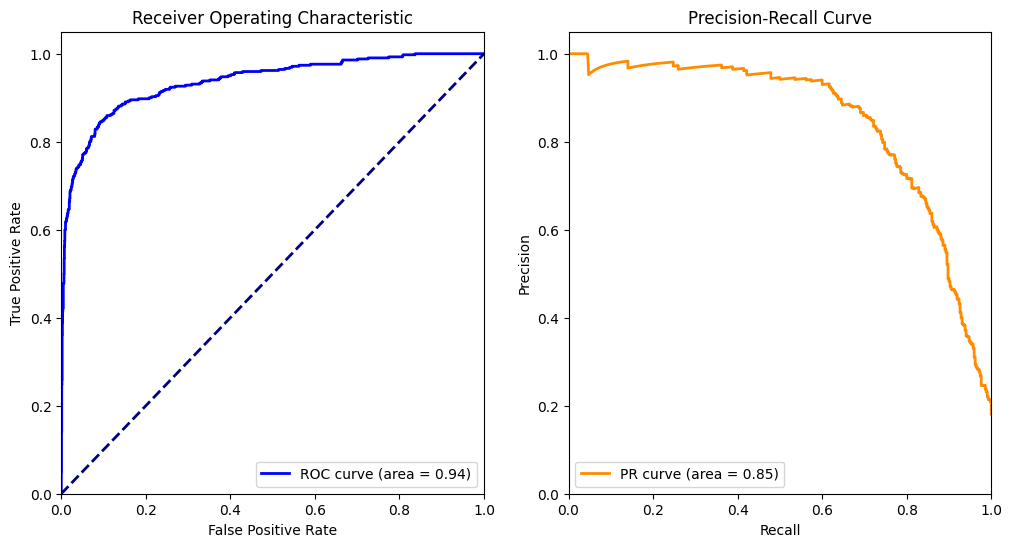

In [106]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

## 2.4 Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

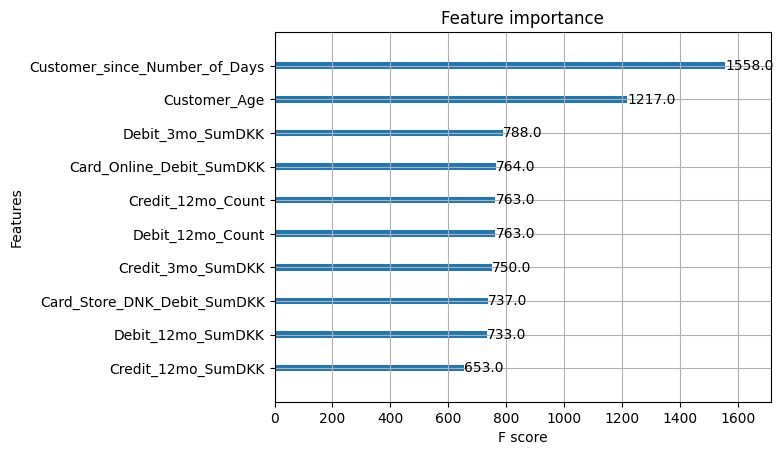

In [128]:
# change the figure size for this plot
xgb.plot_importance(best_model, max_num_features=10)

In [114]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

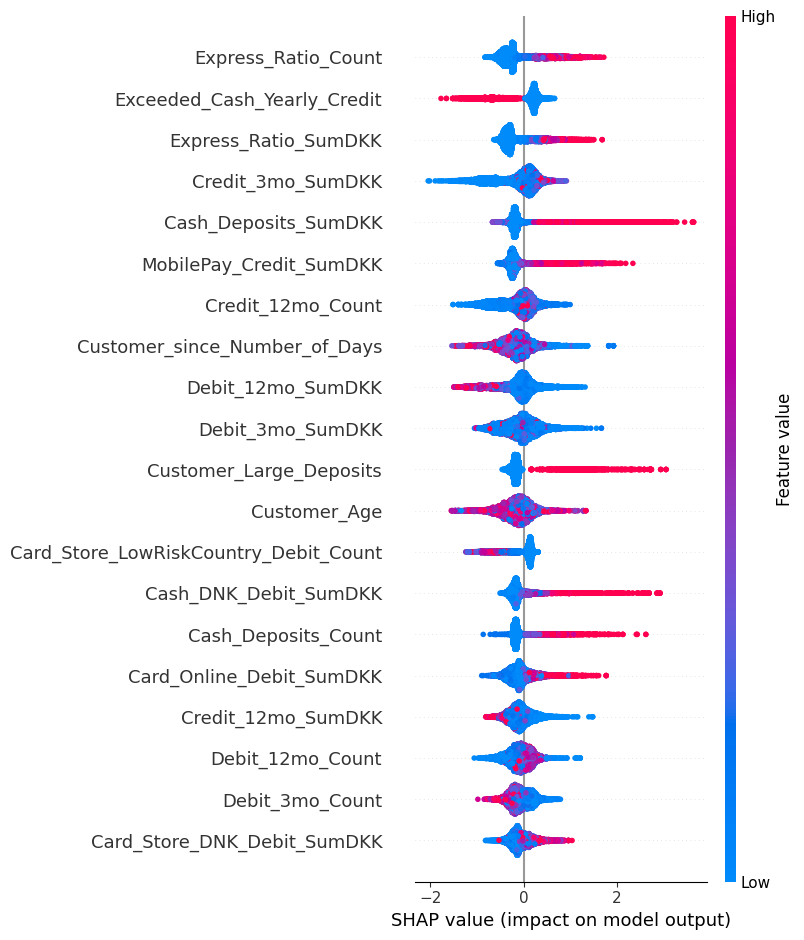

In [121]:
shap.summary_plot(shap_values, X)

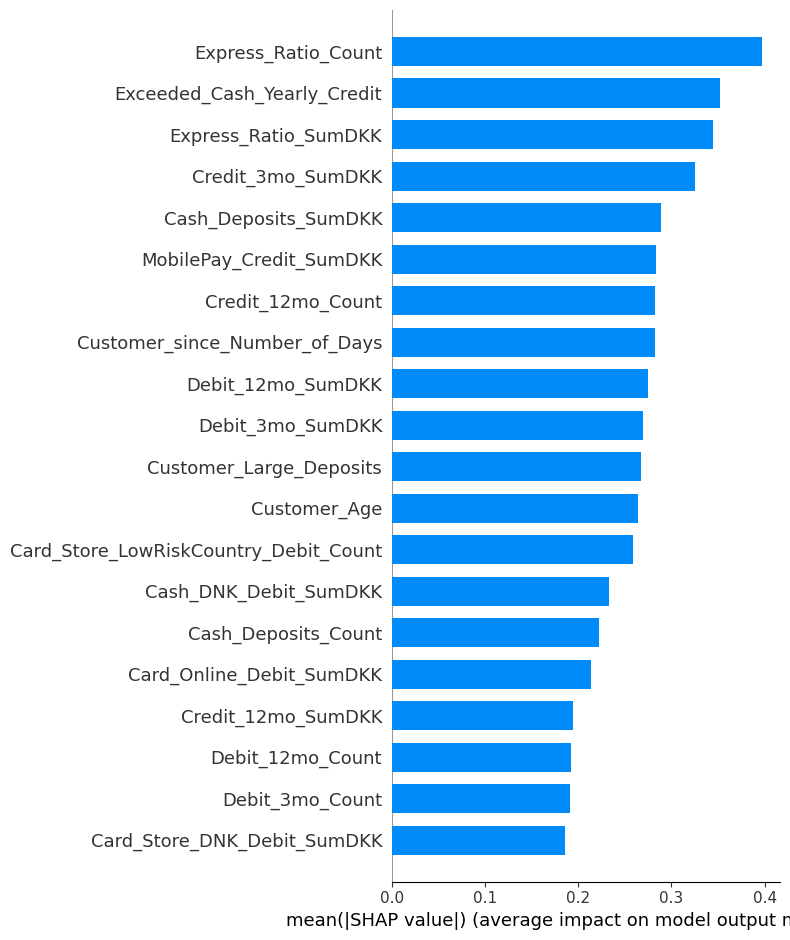

In [116]:
shap.summary_plot(shap_values, X, plot_type="bar")